In [1]:
# FS plot of point amplitudes calculated with Rayleigh-Sommerfeld diffraction formula, 2015-12-22.
#
# BEWARE! This hasn't been tested. It could be full of errors. I've only had a look at the output image
# to confirm that it's roughly square in the middle (the aperture shape) with wavy-looking horizontal 
# and vertical arms (the diffraction patterns.) Since it kind of does I've concluded that the program 
# isn't completely wrong but that doesn't make it right!
#
# The correct answer should look like a Fourier transform of the aperture shape
#
%matplotlib notebook

import numpy as np

from scipy import misc
from scipy import ndimage
from scipy import signal

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
from scipy import misc
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift, fftfreq
from scipy.integrate import dblquad
from numpy.fft import rfft2, irfft2, rfftfreq
from scipy.spatial import distance


In [2]:
%%latex # Here's the R-S formula from the lecture notes 

$$U(P_0) = \frac{A}{j \lambda} \iint \frac{\exp[j k (r_{21} + r_{01})]}{r_{21} r_{01}} \cos(\vec{n}, \vec{r}_{01})$$


<IPython.core.display.Latex object>

In [3]:
# For simplicity, put the origin in the middle of the aperture with source point P2 and image point P0 on the Z axis.
# Look at figure in lecture notes!

wavelength = 532E-9         # Use meters everywhere
k = 2 * np.pi / wavelength  # Wavenumber

# Specify coordinates for the points, aperture center, and image center

P2 = np.array([0, 0, -1000]) # Source point coordinates
P1 = np.array([0, 0, 0])     # Center of aperture
P0 = np.array([0, 0, +1000]) # Center of image plane 
NVec = np.array([0, 0, 1])  # Normal to aperture plane

# Specify size of aperture and image plane

P1max = 100E-3       # A lot bigger than the wavelength so there isn't too much divergence
P0max = P1max * 2    # Image much bigger than aperture to accommodate divergence

P1area = (2 * P1max)**2 + (1j * 0) # Area of aperture

# Specify X,Y,Z coordinates of points in aperture and image planes

# The number of points to sample along each of the X and Y axes.
xypts = 100  # Beware: more than 100 takes a long time (on my laptop)

P1x = np.linspace(-P1max,+P1max, xypts)
P1y = P1x

P0x = np.linspace(-P0max,+P0max, xypts)
P0y = P0x

P1xx, P1yy = np.meshgrid(P1x, P1y)
P1zz = np.full_like(P1xx, P1[2])
P1xyz = np.dstack((P1xx, P1yy, P1zz))

P0xx, P0yy = np.meshgrid(P0x, P0y)
P0zz = np.full_like(P0xx, P0[2])
P0xyz = np.dstack((P0xx, P0yy, P0zz))
 
# Calculate lengths of vectors from source point P2 to aperture points P1

r21Vecs = P1xyz - P2
r21VecNorms = np.linalg.norm(r21Vecs,axis=2)

In [4]:
def RS(P0p):
    "Return the complex-valued phasor for a single point P0p on the image plane P0 calculated by the R-S formula"
    
    r01Vecs = P1xyz - P0p # vectors between the point P0p and lots of points in the aperture plane P1
    r01VecNorms = np.linalg.norm(r01Vecs,axis=2) # Get the magnitudes of the vectors
    
    r01VecNorms3 = np.dstack((r01VecNorms, r01VecNorms, r01VecNorms)) # Ugly but can't think of a better way right now
    r01VecsNormalized = np.divide(r01Vecs, r01VecNorms3)  # Normalize them so they have unit magnitude
    cosNVecr01 = np.dot(r01VecsNormalized, NVec) # Get the Cosine of the angle using the scalar product

    # This is the R-S formula using np.sum for discrete integration over the two dimensions of the aperture
    
    return (P1area / (1j * wavelength)) * \
            np.sum((np.exp(1j * k * (r21VecNorms + r01VecNorms)) / (r21VecNorms * r01VecNorms)) * \
            cosNVecr01)

# Make a version of it to which you can pass arrays or vectors instead of single points
# Can't get it to work right now so used np.apply_along_axis instead, see next cell
#
# VRS = np.vectorize(RS,otypes=[np.complex64]) 

In [5]:
UP0 = RS(P0)
print(UP0)

UP0xy = np.apply_along_axis(RS, 2, P0xyz)
print(UP0xy.shape)

MagSqrdUP0xy = np.real(UP0xy * np.conj(UP0xy)) 
print(MagSqrdUP0xy.shape)

(-2.13286939348-5.1728885127j)
(100, 100)
(100, 100)


<IPython.core.display.Javascript object>


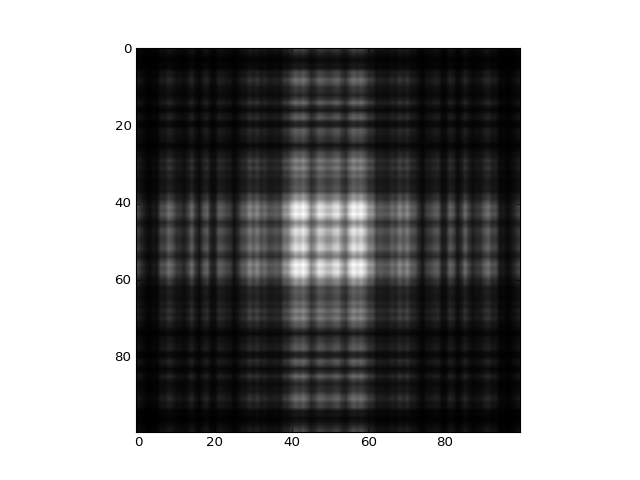

In [6]:
ivkp = plt.figure()
axivkp = ivkp.add_subplot(1,1,1)

plt.imshow(MagSqrdUP0xy, cmap = cm.Greys_r)
#plt.imshow(MagSqrdUP0xy)